# Colorado cannabis sales data 🌳 🚬

Every month, the Colorado Department of Revenue [publishes](https://www.colorado.gov/pacific/revenue/colorado-marijuana-sales-reports) county-level data on retail and medical cannabis sales in the state.

This notebook is intended to show various things you might do in the course of gathering and analyzing data, maybe in a newsroom. It contains, or links to, code that accomplishes the following:
- Downloads the raw .xlsx files into the `raw-data` directory
- Parsees these files into flat CSVs in the `processed-data` directory
- Loads the CSV data into a `pandas` dataframe for analysis (and write out to one big stacked CSV: `./co-cannabis-sales.csv`)
- Downloads the Census TIGER/LINE shapefile of Colorado counties into the `raw-data` directory
- Loads this shapefile into `geopandas`
- Hits the Census Bureau API to get the most recent population estimates for Colorado counties
- Draws a choropleth map with per-capita sales data by county for the most recent year of retail sales

### Prerequisites

If you don't have one already, [grab an API key from the Census Bureau](https://www.census.gov/data/developers/guidance/api-user-guide.Query_Components.html) and save it as an [environment variable](https://en.wikipedia.org/wiki/Environment_variable) called `CENSUS_API_KEY`.

### Import dependencies

In [1]:
import os
import glob
from datetime import date
import csv
import zipfile

import requests
import pandas as pd
import geopandas as gpd
from matplotlib.ticker import FuncFormatter

In [2]:
# display plots inline
%matplotlib inline

# display floats with thousand-separator commas and no decimal points
pd.options.display.float_format = '{:,.0f}'.format

### Download the spreadsheets

Running the next cell fires a separate script, `download.py`, that fetches the page, extracts the relevant `.xlsx` links, checks to see which ones we already have, and downloads the ones we don't.

In [3]:
%run download

raw-data/0620_MarijuanaSalesReport_PUBLISH.xlsx


### Extract the data from the sheets

This one's a little messy. The spreadsheet data is laid out in adjacent tables of varying length -- one for medical sales, one for retail.

![sheet layout](img/sheet-layout.png "Sheet layout")

- Every row in the data is the sum of one month of sales for one category of cannabis ("retail" or "medical") for one county
- Not every county in Colorado has pot shops
- To maintain taxpayer privacy, the state releases aggregate sales data only for counties with at least three dispensaries, and then only if none represent more than 80 percent of total sales, according to the state. Totals for counties that don't meet these criteria are represented in the data as "NR" -- we'll replace these with `None` -- and the total for these "NR" counties is represented in a separate record labeled "Sum of NR Counties"

There's probably a fancy way to handle all of this in pandas but I went with `openpyxl` and a stop/go flag to manage data collection.

Run the next cell to fire a script, `process.py`, that parses the downloaded files and writes them out to CSVs.

In [4]:
%run process

### Load the CSVs into a dataframe

In [5]:
# get a list of the CSV files we just created
processed_files = glob.glob(os.path.join('processed-data', '20*.csv'))

In [6]:
# create a dataframe by concatenating dataframes in a list comprehension
# solution via googling "pandas read_csv multiple files" =>
# https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe#comment57648172_21232849
df = pd.concat([pd.read_csv(f) for f in processed_files])

In [7]:
df.head()

,month,year,county,amount,sales_type
0,4,2016,Adams,"387,146",medical
1,4,2016,Adams,"3,187,313",retail
2,4,2016,Alamosa,nan,medical
3,4,2016,Arapahoe,"7,531,661",retail
4,4,2016,Arapahoe,"1,682,301",medical


In [8]:
# save this stacked dataframe to file
df.to_csv('co-cannabis-sales.csv', index=False)

In [9]:
# check month values
sorted(df.month.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [10]:
# check year values
sorted(df.year.unique())

[2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [11]:
# check county values
sorted(df.county.unique())

['Adams',
 'Alamosa',
 'Arapahoe',
 'Archuleta',
 'Bent',
 'Boulder',
 'Chaffee',
 'Clear Creek',
 'Conejos',
 'Costilla',
 'Crowley',
 'Delta',
 'Denver',
 'Eagle',
 'El Paso',
 'Fremont',
 'Garfield',
 'Gilpin',
 'Grand',
 'Gunnison',
 'Huerfano',
 'Jefferson',
 'La Plata',
 'Lake',
 'Larimer',
 'Las Animas',
 'Mesa',
 'Moffat',
 'Montezuma',
 'Montrose',
 'Morgan',
 'Otero',
 'Ouray',
 'Park',
 'Pitkin',
 'Pueblo',
 'Routt',
 'Saguache',
 'San Juan',
 'San Miguel',
 'Sedgwick',
 'Sum of NR Counties',
 'Summit',
 'Teller',
 'Weld']

In [12]:
# check type values
df.sales_type.unique()

array(['medical', 'retail'], dtype=object)

In [13]:
# create a date column to group by later when we plot
df['date'] = df.apply(lambda x: date(x.year, x.month, 1), axis=1)

In [14]:
# create filtered dataframes for medical and retail data
retail = df[df.sales_type == 'retail']
med = df[df.sales_type == 'medical']

### Do some basic analysis

In [15]:
# sum
df.amount.sum()

8403155438.0

In [16]:
# sum by year
df[['year', 'amount']].groupby('year').sum()

,amount
year,
2014,"683,523,739"
2015,"995,591,255"
2016,"1,307,203,473"
2017,"1,502,047,770"
2018,"1,451,843,172"
2019,"1,595,903,097"
2020,"867,042,932"


In [17]:
# sum by county by year
pd.pivot_table(df,
               index='county',
               values='amount',
               columns='year',
               aggfunc=sum)

year,2014,2015,2016,2017,2018,2019,2020
county,,,,,,,
Adams,"8,531,797","24,826,654","49,810,527","73,319,607","89,595,114","115,030,166","70,878,022"
Alamosa,0,0,0,0,0,0,0
Arapahoe,"19,083,212","68,533,185","113,890,135","124,313,953","129,801,179","153,255,179","84,372,939"
Archuleta,0,0,0,"6,397,396","8,848,341","10,248,743","6,007,772"
Bent,nan,nan,nan,nan,nan,0,"504,288"
Boulder,"62,935,522","82,465,474","95,408,126","99,923,326","108,277,854","116,859,122","61,158,207"
Chaffee,"438,160","2,067,869","3,492,699","5,422,335","5,360,100","4,330,415","3,348,078"
Clear Creek,"6,095,765","6,435,080","7,414,079","7,262,477","7,425,243","7,950,847","3,833,644"
Conejos,nan,0,"3,522,183","5,426,288","6,033,662","1,314,361",0


In [18]:
# for all years, what percentage of total sales do the "NR Counties" contribute?
(df[df.county == 'Sum of NR Counties'].amount.sum() / df.amount.sum()) * 100

2.8329495480171554

### Let's make a line chart

Specifically, let's replicate the line chart from the state webpage:

![official chart](img/mjsales.jpg "Official chart")

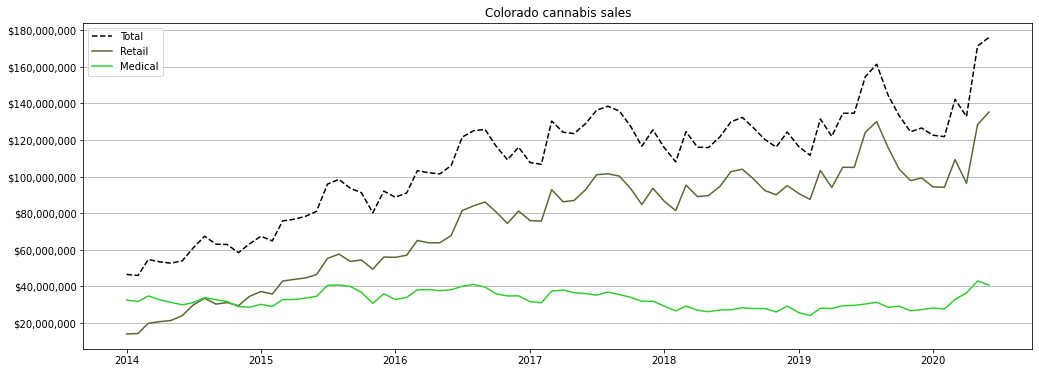

In [19]:
# chart totals by month, each type

# groupby objects for total, medical and retail dataframes
total_grouped = df[['date', 'amount']].groupby('date').sum()
med_grouped = med[['date', 'amount']].groupby('date').sum()
retail_grouped = retail[['date', 'amount']].groupby('date').sum()

# start with totals to create the chart
linechart = total_grouped.plot(color='black',
                               figsize=(17, 6),
                               title='Colorado cannabis sales',
                               linestyle='--')

# plot retail
retail_grouped.plot(ax=linechart, color='DarkOliveGreen')

# plot medical
med_grouped.plot(ax=linechart, color='LimeGreen')

# set the legend
linechart.legend(['Total', 'Retail', 'Medical'])

# turn major gridlines on
linechart.grid(True, which='major', axis='y')

# blank axis labels -- seems like it's implied?
linechart.set_xlabel('')
linechart.set_ylabel('')

# format y axis values
linechart.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:,.0f}'.format(y))) 

### A function to download a GIS file of Colorado counties

In [20]:
def get_co_county_gis_data():
    '''download a zipped shapefile of Colorado counties'''

    url = 'https://www2.census.gov/geo/tiger/TIGER2010/COUNTY/2000/tl_2010_08_county00.zip'
    fname = os.path.join('raw-data', url.split('/')[-1])    
    
    # if it's not here already ...
    if not os.path.isfile(fname):
        
        # fetch it
        r = requests.get(url)

        # and write it to file
        with open(fname, 'wb') as f:

            for block in r.iter_content(1024):
                f.write(block)

    return fname

In [21]:
# fetch the GIS data and assign what's returned (the filename) to a variable
geodata = get_co_county_gis_data()

# unzip the file
with zipfile.ZipFile(geodata, 'r') as z:
    z.extractall('raw-data')

### Load the GIS data into geopandas

In [22]:
# the shapefile naming convention is the same, so get the root filename + '.shp'
shp = geodata.split('.zip')[0] + '.shp'

# and load it into a geodataframe
gdf = gpd.read_file(shp)

In [23]:
gdf.head()

,STATEFP00,COUNTYFP00,CNTYIDFP00,NAME00,NAMELSAD00,LSAD00,CLASSFP00,MTFCC00,UR00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,geometry
0,08,013,08013,Boulder,Boulder County,06,H1,G4020,M,A,1908733293,36715760,+40.0866321,-105.3590729,"POLYGON ((-105.16615 39.91405, -105.16657 39.9..."
1,08,069,08069,Larimer,Larimer County,06,H1,G4020,M,A,6723614521,98295250,+40.6630912,-105.4821309,"POLYGON ((-105.05672 40.34928, -105.05670 40.3..."
2,08,071,08071,Las Animas,Las Animas County,06,H1,G4020,M,A,12361162110,6929979,+37.3188308,-104.0441103,"POLYGON ((-104.14318 37.75833, -104.12615 37.7..."
3,08,043,08043,Fremont,Fremont County,06,H1,G4020,M,A,3970618782,2235223,+38.4556576,-105.4214383,"POLYGON ((-105.36889 38.25940, -105.36909 38.2..."
4,08,041,08041,El Paso,El Paso County,06,H1,G4020,M,A,5508385644,7111582,+38.8273831,-104.5274718,"POLYGON ((-104.93899 38.79201, -104.93898 38.7..."


### Grab population data from the Census

In [24]:
# grab environmental variable with API key
census_api_key = os.environ.get('CENSUS_API_KEY')

In [25]:
def get_county_pop(target_year):
    
    # endpoint for latest-ish population estimates
    endpoint = f'https://api.census.gov/data/{target_year}/pep/population'

    # URL parameters to target info we want
    params = {
        'get': 'GEONAME,POP',
        'for': 'county:*',
        'in': 'state:08',
        'key': census_api_key
    }

    # request data from the API
    r = requests.get(endpoint, params=params)
    r.raise_for_status()
    
    # turn the response into Python data objects
    j = r.json()
    
    # get the headers from the first record
    headers = j[0]
    
    # return a dict of the list of data
    return [dict(zip(headers, x)) for x in j[1:]]

In [26]:
# if it's after october, use last year for all things
if date.today().month > 10:
    target_year = date.today().year - 1
# otherwise, the pop data will be 2 years old
else:
    target_year = date.today().year - 2

In [27]:
cpop = get_county_pop(target_year)
popfile = os.path.join('processed-data', f'colorado-county-pop-estimates-{target_year}.csv')

# write out population data to file
with open(popfile, 'w') as o:
    headers = list(cpop[0].keys())
    writer = csv.DictWriter(o, fieldnames=headers)
    writer.writeheader()
    writer.writerows(cpop)

In [28]:
# read the data into a dataframe, preserving the FIPS codes as strings
pop_df = pd.read_csv(popfile,
                     dtype={'state': str, 'county': str, 'POP': float})

In [29]:
pop_df.head()

,GEONAME,POP,state,county
0,"Adams County, Colorado","511,868",08,001
1,"Alamosa County, Colorado","16,683",08,003
2,"Arapahoe County, Colorado","651,215",08,005
3,"Archuleta County, Colorado","13,765",08,007
4,"Baca County, Colorado","3,585",08,009


In [30]:
# combine county and state FIPS
pop_df['fips'] = pop_df['state'] + pop_df['county']

In [31]:
pop_df.head()

,GEONAME,POP,state,county,fips
0,"Adams County, Colorado","511,868",08,001,08001
1,"Alamosa County, Colorado","16,683",08,003,08003
2,"Arapahoe County, Colorado","651,215",08,005,08005
3,"Archuleta County, Colorado","13,765",08,007,08007
4,"Baca County, Colorado","3,585",08,009,08009


### Map: Per-capita sales analysis

We'll look at the most recent retail sales data -- [checking this researcher's work, basically](https://www.thecannabist.co/2018/02/09/colorado-marijuana-sales-southern-border/98669/). Our steps:

1. Merge our GIS dataframe with the population data
2. Merge the result with the cannabis sales data
3. Calculate the per-capita rate
4. Plot on a map

In [32]:
geo_pop_df = pd.merge(gdf,
                      pop_df,
                      how='left',
                      left_on='CNTYIDFP00',
                      right_on='fips')[['fips', 'NAME00', 'geometry', 'POP']]

In [33]:
geo_pop_df.head()

,fips,NAME00,geometry,POP
0,08013,Boulder,"POLYGON ((-105.16615 39.91405, -105.16657 39.9...","326,078"
1,08069,Larimer,"POLYGON ((-105.05672 40.34928, -105.05670 40.3...","350,518"
2,08071,Las Animas,"POLYGON ((-104.14318 37.75833, -104.12615 37.7...","14,503"
3,08043,Fremont,"POLYGON ((-105.36889 38.25940, -105.36909 38.2...","48,021"
4,08041,El Paso,"POLYGON ((-104.93899 38.79201, -104.93898 38.7...","713,856"


In [34]:
# filter to get latest retail sales data
latest_retail = retail[retail['year'] == target_year]

In [35]:
# group by county and sum the amounts
latest_retail_group = latest_retail[['county', 'amount']].groupby('county').sum().reset_index()

In [36]:
# merge that with the dataframe we merged earlier
latest_retail_map = pd.merge(geo_pop_df,
                             latest_retail_group,
                             how='left',
                             left_on='NAME00',
                             right_on='county')[['fips', 'NAME00', 'geometry', 'POP', 'amount']]

In [37]:
latest_retail_map.head()

,fips,NAME00,geometry,POP,amount
0,08013,Boulder,"POLYGON ((-105.16615 39.91405, -105.16657 39.9...","326,078","90,061,874"
1,08069,Larimer,"POLYGON ((-105.05672 40.34928, -105.05670 40.3...","350,518","73,227,866"
2,08071,Las Animas,"POLYGON ((-104.14318 37.75833, -104.12615 37.7...","14,503","50,349,759"
3,08043,Fremont,"POLYGON ((-105.36889 38.25940, -105.36909 38.2...","48,021",nan
4,08041,El Paso,"POLYGON ((-104.93899 38.79201, -104.93898 38.7...","713,856",0


In [38]:
# calculate the per-capita rate
latest_retail_map['per_capita'] = latest_retail_map['amount'] / latest_retail_map['POP']

In [39]:
latest_retail_map.sort_values('per_capita', ascending=False).head()

,fips,NAME00,geometry,POP,amount,per_capita
2,08071,Las Animas,"POLYGON ((-104.14318 37.75833, -104.12615 37.7...","14,503","50,349,759","3,472"
44,08091,Ouray,"POLYGON ((-107.95565 38.22649, -107.95659 38.2...","4,833","5,542,993","1,147"
24,08023,Costilla,"POLYGON ((-105.73841 37.30676, -105.73842 37.3...","3,828","4,172,958","1,090"
29,08083,Montezuma,"POLYGON ((-109.04583 37.32684, -109.04584 37.3...","26,158","22,451,720",858
56,08019,Clear Creek,"POLYGON ((-105.72413 39.81902, -105.72388 39.8...","9,605","7,176,338",747


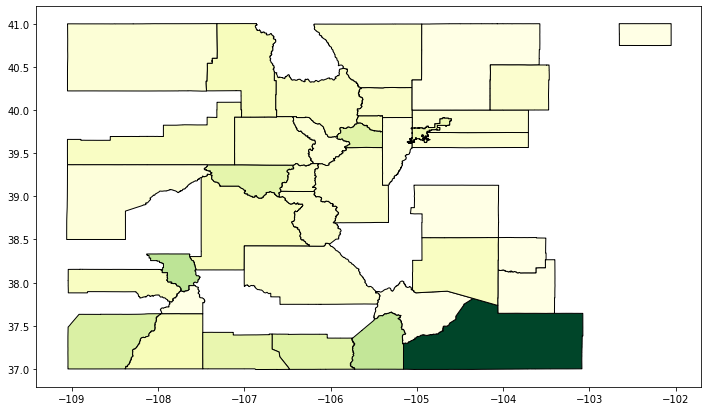

In [40]:
# plot on a map
latest_retail_map.plot(column='per_capita',
                       edgecolor='black',
                       cmap='YlGn', 
                       figsize=(13,7))